In [1]:
import os
import sys

def set_root_path():
    if os.getcwd().endswith('figures'): 
        os.chdir('../')
set_root_path()
sys.path.append('python/')
sys.path = [p for p in sys.path if "unbiased-inverse-volume-rendering" not in p]
print(os.getcwd())
print(sys.executable)
os.environ.pop("PYTHONPATH")

c:\Users\mayuf\source\repos\practical-inverse-rendering-of-textured-and-translucent-appearance
c:\Users\mayuf\anaconda3\envs\practical-inverse-rendering\python.exe


'C:\\Users\\mayuf\\source\\repos\\unbiased-inverse-volume-rendering\\mitsuba3\\build\\Release\\python'

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import mitsuba as mi
import drjit as dr
import numpy as np

from practical_reconstruction import figutils
from practical_reconstruction import scene_configuration
from practical_reconstruction import io_utils
from practical_reconstruction import optimization_cli
from core import integrators
from core import bsdfs
from core import textures

mi.set_variant("cuda_ad_rgb")

from core import integrators
from core import bsdfs
from core import textures
from core import emitters

integrators.register()
bsdfs.register()
textures.register()
emitters.register()

In [3]:
def load_modified_scene(scene_config, res=[400, 240]):
  os.makedirs(scene_config.result_folder,exist_ok=True)

  tmp_mitsuba_xml = io_utils.mitsuba_remote_to_local(scene_config,override=True)
  scene = mi.load_file(tmp_mitsuba_xml)
  params = mi.traverse(scene)

  params.update()
  return scene

In [4]:
def update_light_position(params, camera_idx):
    light_positions = [
["-6.500000 0.000000 0.000000 0.300000 0.000001 4.980974 0.043578 5.564221 -0.000001 0.435778 -0.498097 4.480974 0.000000 0.000000 0.000000 1.000000"],
["-6.500000 0.000001 -0.000000 0.300000 0.000001 4.980973 -0.043578 6.435779 -0.000000 -0.435780 -0.498097 4.480974 0.000000 0.000000 0.000000 1.000000"],
["-6.351649 -0.111248 -0.105630 1.356295 0.000001 4.972498 -0.052370 6.523700 1.380779 -0.511746 -0.485901 4.359011 0.000000 0.000000 0.000000 1.000000"],
["-6.351649 -0.292981 -0.102093 1.320930 0.000001 4.806015 -0.137921 7.379209 1.380779 -1.347730 -0.469633 4.196327 0.000000 0.000000 0.000000 1.000000"],
["-6.495393 -0.088996 0.016586 0.134141 0.000000 4.405818 0.236406 3.635943 -0.244695 2.362381 -0.440270 3.902695 0.000000 0.000000 0.000000 1.000000"],
["-6.495393 -0.058843 0.017879 0.121207 0.000000 4.749398 0.156308 4.436921 -0.244695 1.561971 -0.474603 4.246031 0.000000 0.000000 0.000000 1.000000"],
["-6.168086 0.470791 0.150544 -1.205442 0.000000 4.772093 -0.149236 7.492355 -2.050541 -1.416151 -0.452841 4.028413 0.000000 0.000000 0.000000 1.000000"],
["-6.168086 0.725055 0.140082 -1.100819 -0.000001 4.440450 -0.229835 8.298348 -2.050540 -2.180987 -0.421370 3.713704 0.000000 0.000000 0.000000 1.000000"],
["-5.463686 0.492355 -0.266341 2.963411 0.000000 4.916698 0.090889 5.091106 3.521098 0.763986 -0.413281 3.632814 0.000000 0.000000 0.000000 1.000000"],
["-5.463686 0.022379 -0.270844 3.008444 0.000000 4.999829 0.004131 5.958689 3.521098 0.034725 -0.420269 3.702692 0.000000 0.000000 0.000000 1.000000"],
["-5.470313 -1.096791 0.246786 -2.167863 -0.000001 4.569083 0.203064 3.969364 -3.510794 1.708955 -0.384528 3.345279 0.000000 0.000000 0.000000 1.000000"],
["-5.470313 -0.651588 0.262083 -2.320827 -0.000000 4.852284 0.120637 4.793627 -3.510794 1.015267 -0.408362 3.583618 0.000000 0.000000 0.000000 1.000000"],
["-6.340923 -0.619251 -0.090842 1.208421 -0.000001 4.131406 -0.281629 8.816291 1.429231 -2.747365 -0.403030 3.530296 0.000000 0.000000 0.000000 1.000000"],
["-6.340923 -0.767587 -0.078709 1.087088 0.000001 3.579597 -0.349091 9.490915 1.429231 -3.405480 -0.349199 2.991992 0.000000 0.000000 0.000000 1.000000"],
["-5.923949 1.413812 -0.149531 1.795307 0.000001 3.633151 0.343514 2.564856 2.675224 3.130710 -0.331117 2.811170 0.000000 0.000000 0.000000 1.000000"],
["-5.923949 1.132676 -0.171810 2.018096 0.000000 4.174462 0.275207 3.247933 2.675225 2.508169 -0.380451 3.304507 0.000000 0.000000 0.000000 1.000000"],
["-4.525468 0.604075 0.353791 -3.237914 0.000001 4.928673 -0.084154 6.841537 -4.665848 -0.585900 -0.343147 2.931470 0.000000 0.000000 0.000000 1.000000"],
["-4.525468 1.209250 0.337927 -3.079269 0.000001 4.707664 -0.168461 7.684607 -4.665848 -1.172866 -0.327760 2.777598 0.000000 0.000000 0.000000 1.000000"],
["-4.304457 -0.790902 -0.366210 3.962096 -0.000001 4.887320 -0.105551 7.055512 4.870488 -0.698985 -0.323650 2.736502 0.000000 0.000000 0.000000 1.000000"],
["-4.304458 -1.414803 -0.346912 3.769122 -0.000001 4.629783 -0.188815 7.888151 4.870486 -1.250379 -0.306595 2.565955 0.000000 0.000000 0.000000 1.000000"],
["-5.629383 -1.966910 0.154266 -1.242665 0.000001 3.085686 0.393428 2.065722 -3.249623 3.407316 -0.267239 2.172386 0.000000 0.000000 0.000000 1.000000"],
["-5.629383 -1.669147 0.186078 -1.560779 0.000001 3.721989 0.333868 2.661317 -3.249623 2.891496 -0.322346 2.723460 0.000000 0.000000 0.000000 1.000000"],
["-5.920268 1.528452 0.138724 -1.087242 -0.000001 3.360365 -0.370242 9.702425 -2.683361 -3.372207 -0.306066 2.560656 0.000000 0.000000 0.000000 1.000000"],
["-5.920269 1.746123 0.110075 -0.800754 -0.000001 2.666393 -0.422970 10.229698 -2.683361 -3.852454 -0.242858 1.928580 0.000000 0.000000 0.000000 1.000000"],
["-3.675665 2.095838 -0.355149 3.851489 0.000000 4.306103 0.254116 3.458842 5.360922 1.436991 -0.243505 1.935045 0.000000 0.000000 0.000000 1.000000"],
["-3.675665 1.447288 -0.386147 4.161473 -0.000000 4.681951 0.175480 4.245195 5.360922 0.992319 -0.264758 2.147582 0.000000 0.000000 0.000000 1.000000"],
["-3.107382 -1.205280 0.422301 -3.923008 0.000001 4.808008 0.137224 4.627755 -5.709131 0.656014 -0.229851 1.798510 0.000000 0.000000 0.000000 1.000000"],
["-3.107382 -0.453653 0.436815 -4.068145 0.000001 4.973251 0.051650 5.483504 -5.709131 0.246916 -0.237751 1.877506 0.000000 0.000000 0.000000 1.000000"],
["-4.135763 -2.613756 -0.283677 3.136768 0.000000 3.677116 -0.338804 9.388041 5.014525 -2.155713 -0.233964 1.839643 0.000000 0.000000 0.000000 1.000000"],
["-4.135762 -3.066647 -0.233980 2.639798 -0.000001 3.032926 -0.397509 9.975092 5.014526 -2.529236 -0.192976 1.429763 0.000000 0.000000 0.000000 1.000000"],
["-6.216394 1.381900 -0.047364 0.773643 -0.000000 1.621159 0.472989 1.270112 1.899062 4.523516 -0.155043 1.050425 0.000000 0.000000 0.000000 1.000000"],
["-6.216394 1.278659 -0.070641 1.006412 -0.000000 2.417867 0.437652 1.623480 1.899062 4.185565 -0.231237 1.812371 0.000000 0.000000 0.000000 1.000000"],
["-2.830673 2.397600 0.380923 -3.509235 0.000001 4.231568 -0.266342 8.663424 -5.851264 -1.159890 -0.184280 1.342797 0.000000 0.000000 0.000000 1.000000"],
["-2.830673 3.022642 0.333502 -3.035025 -0.000000 3.704782 -0.335777 9.357765 -5.851264 -1.462267 -0.161339 1.113389 0.000000 0.000000 0.000000 1.000000"],
["-1.991337 0.228000 -0.475412 5.054116 0.000000 4.994260 0.023952 5.760482 6.187453 0.073378 -0.153004 1.030039 0.000000 0.000000 0.000000 1.000000"],
["-1.991337 -0.601007 -0.472148 5.021482 -0.000001 4.959978 -0.063137 6.631364 6.187453 -0.193424 -0.151954 1.019536 0.000000 0.000000 0.000000 1.000000"],
["-2.352270 -3.455790 0.312785 -2.827851 -0.000000 3.355264 0.370705 2.292952 -6.059441 1.341535 -0.121423 0.714229 0.000000 0.000000 0.000000 1.000000"],
["-2.352270 -2.860144 0.368042 -3.380423 -0.000000 3.948012 0.306809 2.931906 -6.059441 1.110305 -0.142874 0.928737 0.000000 0.000000 0.000000 1.000000"],
["-6.373149 -0.933616 -0.030760 0.607603 0.000001 1.564636 -0.474889 10.748886 1.277880 -4.656209 -0.153410 1.034102 0.000000 0.000000 0.000000 1.000000"],
["-6.373149 -0.972847 -0.014081 0.440809 0.000001 0.716232 -0.494844 10.948436 1.277880 -4.851864 -0.070225 0.202254 0.000000 0.000000 0.000000 1.000000"],
["-1.819810 3.883368 -0.282132 3.121323 -0.000000 2.938852 0.404514 1.954861 6.240055 1.132521 -0.082279 0.322793 0.000000 0.000000 0.000000 1.000000"],
["-1.819809 3.334453 -0.345280 3.752800 -0.000000 3.596635 0.347336 2.526642 6.240056 0.972438 -0.100695 0.506953 0.000000 0.000000 0.000000 1.000000"],
["-0.936766 0.223066 0.494277 -4.642772 0.000000 4.994916 -0.022542 6.225419 -6.432144 -0.032487 -0.071986 0.219856 0.000000 0.000000 0.000000 1.000000"],
["-0.936767 1.077980 0.482894 -4.528945 -0.000000 4.879889 -0.108935 7.089352 -6.432143 -0.156996 -0.070328 0.203279 0.000000 0.000000 0.000000 1.000000"],
["-0.805985 -2.452259 -0.431301 4.613009 0.000000 4.346553 -0.247133 8.471331 6.449836 -0.306439 -0.053896 0.038963 0.000000 0.000000 0.000000 1.000000"],
["-0.805985 -3.163949 -0.382165 4.121655 0.000000 3.851377 -0.318856 9.188557 6.449836 -0.395374 -0.047756 -0.022438 0.000000 0.000000 0.000000 1.000000"],
["-1.749547 -4.766867 0.068249 -0.382485 0.000000 0.708638 0.494953 1.050471 -6.260118 1.332221 -0.019074 -0.309262 0.000000 0.000000 0.000000 1.000000"],
["-1.749547 -4.575935 0.149987 -1.199874 0.000001 1.557348 0.475128 1.248719 -6.260118 1.278860 -0.041918 -0.080822 0.000000 0.000000 0.000000 1.000000"],
["-0.266642 4.100574 0.285363 -2.553634 -0.000001 2.856037 -0.410403 10.104029 -6.494529 -0.168355 -0.011716 -0.382840 0.000000 0.000000 0.000000 1.000000"],
["-0.266642 4.533805 0.209822 -1.798224 -0.000001 2.099991 -0.453763 10.537625 -6.494529 -0.186142 -0.008614 -0.413855 0.000000 0.000000 0.000000 1.000000"],
["0.139237 1.928305 -0.461196 4.911959 0.000000 4.613018 0.192875 4.071251 6.498508 -0.041316 0.009882 -0.598816 0.000000 0.000000 0.000000 1.000000"],
["0.139238 1.098152 -0.487674 5.176740 0.000001 4.877859 0.109840 4.901595 6.498508 -0.023530 0.010449 -0.604489 0.000000 0.000000 0.000000 1.000000"],
["0.438206 -2.475323 0.433118 -4.031183 0.000001 4.341060 0.248097 3.519032 -6.485212 -0.167257 0.029266 -0.792659 0.000000 0.000000 0.000000 1.000000"],
["0.438206 -1.685616 0.469522 -4.395218 0.000001 4.705925 0.168946 4.310541 -6.485212 -0.113896 0.031726 -0.817256 0.000000 0.000000 0.000000 1.000000"],
["1.669134 -4.250199 -0.229941 2.599409 0.000000 2.379190 -0.439766 10.397665 6.282037 1.129275 0.061095 -1.110952 0.000000 0.000000 0.000000 1.000000"],
["1.669135 -4.584918 -0.152644 1.826437 -0.000001 1.579397 -0.474400 10.743998 6.282037 1.218211 0.040557 -0.905573 0.000000 0.000000 0.000000 1.000000"],
["2.549824 4.413087 -0.129521 1.595207 -0.000001 1.408070 0.479764 1.202361 5.978996 -1.882020 0.055236 -1.052359 0.000000 0.000000 0.000000 1.000000"],
["2.549825 4.121131 -0.204185 2.341855 -0.000001 2.219780 0.448024 1.519757 5.978996 -1.757513 0.087078 -1.370777 0.000000 0.000000 0.000000 1.000000"],
["1.342484 1.849582 0.452909 -4.229086 0.000000 4.628890 -0.189034 7.890338 -6.359854 0.390423 0.095603 -1.456033 0.000000 0.000000 0.000000 1.000000"],
["1.342483 2.607949 0.413910 -3.839103 -0.000001 4.230313 -0.266542 8.665418 -6.359854 0.550504 0.087371 -1.373713 0.000000 0.000000 0.000000 1.000000"],
["1.506390 -0.792885 -0.479881 5.098813 0.000000 4.933118 -0.081508 6.815074 6.323036 0.188896 0.114326 -1.643263 0.000000 0.000000 0.000000 1.000000"],
["1.506391 -1.614144 -0.458823 4.888226 -0.000000 4.716637 -0.165932 7.659318 6.323036 0.384551 0.109309 -1.593093 0.000000 0.000000 0.000000 1.000000"],
["2.947504 -3.827540 0.228238 -1.982376 0.000001 2.560797 0.429445 1.705547 -5.793291 -1.947371 0.116122 -1.661225 0.000000 0.000000 0.000000 1.000000"],
["2.947504 -3.373060 0.291235 -2.612346 0.000000 3.267617 0.378453 2.215467 -5.793291 -1.716142 0.148174 -1.981741 0.000000 0.000000 0.000000 1.000000"],
["5.750979 2.107673 0.099370 -0.693701 0.000000 2.132242 -0.452256 10.522560 -3.029231 4.001407 0.188654 -2.386537 0.000000 0.000000 0.000000 1.000000"],
["5.750979 2.248207 0.061261 -0.312611 -0.000000 1.314516 -0.482411 10.824112 -3.029230 4.268209 0.116304 -1.663039 0.000000 0.000000 0.000000 1.000000"],
["2.754608 2.914008 -0.346680 3.766799 0.000001 3.827493 0.321719 2.782811 5.887456 -1.363399 0.162204 -2.122038 0.000000 0.000000 0.000000 1.000000"],
["2.754610 2.267734 -0.392014 4.220143 0.000000 4.328003 0.250367 3.496325 5.887455 -1.061023 0.183415 -2.334148 0.000000 0.000000 0.000000 1.000000"],
["2.527739 -0.749553 0.454504 -4.245043 0.000000 4.933362 0.081359 5.186406 -5.988367 -0.316392 0.191850 -2.418501 0.000000 0.000000 0.000000 1.000000"],
["2.527740 0.051072 0.460615 -4.306152 0.000001 4.999693 -0.005544 6.055436 -5.988366 0.021559 0.194430 -2.444295 0.000000 0.000000 0.000000 1.000000"],
["3.722163 -2.440898 -0.329304 3.593037 0.000000 4.016846 -0.297741 8.977407 5.328743 1.704984 0.230021 -2.800209 0.000000 0.000000 0.000000 1.000000"],
["3.722165 -2.975644 -0.281915 3.119151 -0.000000 3.438800 -0.362969 9.629691 5.328742 2.078509 0.196920 -2.469197 0.000000 0.000000 0.000000 1.000000"],
["6.499726 -0.042236 0.001792 0.282076 0.000000 1.953322 0.460267 1.397334 -0.059647 -4.602472 0.195324 -2.453240 0.000000 0.000000 0.000000 1.000000"],
["6.499726 -0.038482 0.002499 0.275014 0.000000 2.722891 0.419355 1.806449 -0.059647 -4.193374 0.272278 -3.222776 0.000000 0.000000 0.000000 1.000000"],
["4.302104 2.126667 0.308638 -2.786381 0.000000 4.117231 -0.283697 8.836971 -4.872566 1.877685 0.272504 -3.225041 0.000000 0.000000 0.000000 1.000000"],
["4.302106 2.630301 0.267020 -2.370201 0.000001 3.562047 -0.350882 9.508821 -4.872564 2.322357 0.235758 -2.857585 0.000000 0.000000 0.000000 1.000000"],
["3.592301 0.681786 -0.411088 4.410876 -0.000000 4.932622 0.081807 5.181928 5.417137 -0.452117 0.272607 -3.226071 0.000000 0.000000 0.000000 1.000000"],
["3.592301 -0.042418 -0.416681 4.466813 -0.000001 4.999741 -0.005090 6.050897 5.417137 0.028130 0.276317 -3.263165 0.000000 0.000000 0.000000 1.000000"],
["4.405419 -2.064547 0.304200 -2.742004 -0.000000 4.137170 0.280781 3.192185 -4.779360 -1.903015 0.280400 -3.303995 0.000000 0.000000 0.000000 1.000000"],
["4.405418 -1.504943 0.335429 -3.054294 -0.000000 4.561890 0.204674 3.953254 -4.779361 -1.387195 0.309185 -3.591851 0.000000 0.000000 0.000000 1.000000"],
["6.349392 -0.751830 -0.076148 1.061480 0.000000 3.558008 -0.351292 9.512916 1.391121 3.431520 0.347557 -3.975567 0.000000 0.000000 0.000000 1.000000"],
["6.349392 -0.872637 -0.061936 0.919358 -0.000000 2.893942 -0.407739 10.077388 1.391121 3.982914 0.282689 -3.326889 0.000000 0.000000 0.000000 1.000000"],
["5.611467 1.744335 -0.182346 2.123461 0.000000 3.613056 0.345627 2.543726 3.280463 -2.983810 0.311916 -3.619161 0.000000 0.000000 0.000000 1.000000"],
["5.611467 1.401194 -0.209866 2.398659 0.000000 4.158341 0.277636 3.223635 3.280463 -2.396843 0.358991 -4.089907 0.000000 0.000000 0.000000 1.000000"],
["4.724389 0.338686 0.341735 -3.117350 -0.000000 4.975624 -0.049312 6.493123 -4.464319 0.358416 0.361643 -4.116428 0.000000 0.000000 0.000000 1.000000"],
["4.724389 0.926957 0.330662 -3.006620 0.000001 4.814403 -0.134964 7.349639 -4.464319 0.980958 0.349925 -3.999249 0.000000 0.000000 0.000000 1.000000"],
["5.144022 -0.657265 -0.298507 3.285068 -0.000000 4.883033 -0.107517 7.075168 3.973542 0.850875 0.386437 -4.364375 0.000000 0.000000 0.000000 1.000000"],
["5.144022 -1.165632 -0.282558 3.125585 -0.000000 4.622148 -0.190676 7.906763 3.973542 1.508990 0.365791 -4.157913 0.000000 0.000000 0.000000 1.000000"],
["6.284044 -0.814475 0.098501 -0.685005 0.000000 3.853321 0.318621 2.813792 -1.661563 -3.080349 0.372530 -4.225298 0.000000 0.000000 0.000000 1.000000"],
["6.284044 -0.631057 0.111147 -0.811473 0.000000 4.348059 0.246868 3.531320 -1.661563 -2.386661 0.420360 -4.703599 0.000000 0.000000 0.000000 1.000000"],
["6.310709 0.515261 0.108138 -0.781382 -0.000000 4.513789 -0.215075 8.150745 -1.557224 2.088112 0.438234 -4.882340 0.000000 0.000000 0.000000 1.000000"],
["6.310709 0.695212 0.097548 -0.675479 0.000000 4.071741 -0.290188 8.901881 -1.557224 2.817376 0.395317 -4.453166 0.000000 0.000000 0.000000 1.000000"],
["5.828282 0.641638 -0.211858 2.418579 0.000000 4.785345 0.144930 4.550698 2.877695 -1.299529 0.429082 -4.790822 0.000000 0.000000 0.000000 1.000000"],
["5.828282 0.264003 -0.219781 2.497812 -0.000000 4.964313 0.059632 5.403683 2.877695 -0.534693 0.445130 -4.951295 0.000000 0.000000 0.000000 1.000000"],
["6.010379 -0.385919 0.186428 -1.564277 -0.000000 4.896194 0.101355 4.986453 -2.474943 -0.937200 0.452738 -5.027383 0.000000 0.000000 0.000000 1.000000"],
["6.010379 -0.056327 0.190297 -1.602969 0.000000 4.997811 0.014793 5.852066 -2.474943 -0.136790 0.462134 -5.121345 0.000000 0.000000 0.000000 1.000000"],
["6.428964 -0.116861 -0.072786 1.027864 -0.000000 4.936777 -0.079262 6.792614 0.958341 0.783953 0.488282 -5.382825 0.000000 0.000000 0.000000 1.000000"],
["6.428964 -0.241478 -0.069651 0.996513 0.000000 4.724140 -0.163783 7.637834 0.958341 1.619935 0.467251 -5.172512 0.000000 0.000000 0.000000 1.000000"],
["6.500000 0.000000 0.000000 0.300000 0.000000 4.980974 0.043578 5.564221 0.000000 -0.435778 0.498097 -5.480974 0.000000 0.000000 0.000000 1.000000"],
["6.500000 0.000000 0.000000 0.300000 0.000000 4.980974 -0.043578 6.435779 0.000000 0.435779 0.498097 -5.480974 0.000000 0.000000 0.000000 1.000000"],

    ]
    raw_string = light_positions[camera_idx][0]
    float_values = list(map(float, raw_string.strip().split()))
    matrix_4x4 = np.array(float_values).reshape((4, 4))
    params['arealight.to_world'] = mi.Transform4f(matrix_4x4)
    params.update()

def save_images(scene, params, dir, spp):
    print("start rendering")
    for i, sensor in enumerate(scene.sensors()):
						update_light_position(params, i)
                                                
						# integrator = mi.load_dict({
						# 		'type': 'prb_nee_volume',
						# 		'max_sss_depth': -1,
						# 		'max_path_depth': 256,
						# })
						image = mi.render(scene, sensor=sensor, spp=spp)
						bitmap = mi.Bitmap(image).convert(
										pixel_format=mi.Bitmap.PixelFormat.RGB,
										component_format=mi.Struct.Type.UInt8,
										srgb_gamma=True
						)
						png_path = dir / f"ref_view_{i:03d}.png"
						bitmap.write(str(png_path))

						bitmap = mi.Bitmap(image).convert(
														pixel_format=mi.Bitmap.PixelFormat.RGB,
														component_format=mi.Struct.Type.Float32,
														srgb_gamma=False
						)
						exr_path = dir / f"ref_view_{i:03d}.exr"
						bitmap.write(str(exr_path))
						print(f"saving: {i}")

In [ ]:
# Display reference image
scene_name = 'kiwi_refine'
technique = 'mipmap_pyramid'
result_folder = f'results/{scene_name}/{technique}'
scene_folder = f'third_party/{scene_name}'
result_folder += '_test'

override_bindings = []
override_bindings.append(f"SceneConfig.result_folder='{result_folder}'")
override_bindings.append(f"SceneConfig.scene_folder='{scene_folder}'")
override_bindings.append(f'SceneConfig.base_learning_rate={0.1}')
scene_config = scene_configuration.SceneConfig.get_instance(
				f'{scene_name}/{technique}', override_bindings, sss_config=True
)

scene = load_modified_scene(scene_config,res=[800,480])
ref_spp=4096
opt_spp=128
params = mi.traverse(scene)

ref_dir=Path("third_party/kiwi_refine/references")
ref_scene_path=f'third_party/{scene_name}/mts_scene/kiwi_refine_ref.xml'
ref_scene = mi.load_file(ref_scene_path)
ref_params = mi.traverse(ref_scene)
#save_images(ref_scene, ref_params, ref_dir, ref_spp)

test_dir=Path("third_party/kiwi_refine/test")
test_scene_path=f'third_party/{scene_name}/mts_scene/kiwi_test.xml'
test_scene = mi.load_file(test_scene_path)
test_params = mi.traverse(test_scene)
#print(test_scene)
#save_images(test_scene, test_params, test_dir, ref_spp)

start rendering
saving: 0
saving: 1
saving: 2
saving: 3
saving: 4
saving: 5
saving: 6
saving: 7
saving: 8
saving: 9
saving: 10
saving: 11
saving: 12
saving: 13
saving: 14
saving: 15
saving: 16
saving: 17
saving: 18
saving: 19
saving: 20
saving: 21
saving: 22
saving: 23
saving: 24
saving: 25
saving: 26
saving: 27
saving: 28
saving: 29
saving: 30
saving: 31
saving: 32
saving: 33
saving: 34
saving: 35
saving: 36
saving: 37
saving: 38
saving: 39
saving: 40
saving: 41
saving: 42
saving: 43
saving: 44
saving: 45
saving: 46
saving: 47
saving: 48
saving: 49
saving: 50
saving: 51
saving: 52
saving: 53
saving: 54
saving: 55
saving: 56
saving: 57
saving: 58
saving: 59
saving: 60
saving: 61
saving: 62
saving: 63
saving: 64
saving: 65
saving: 66
saving: 67
saving: 68
saving: 69
saving: 70
saving: 71
saving: 72
saving: 73
saving: 74
saving: 75
saving: 76
saving: 77
saving: 78
saving: 79
saving: 80
saving: 81
saving: 82
saving: 83
saving: 84
saving: 85
saving: 86
saving: 87
saving: 88
saving: 89
savi

Next result location: results/kiwi_refine/mipmap_pyramid_test
SceneConfig(approach=<Approach.MIPMAP_PYRAMID: 2>, scene_setup=<Setup.FULL_ON: 0>, random_lights=0, random_sensors=True, envmap_rotations=[0.0, 45.0], extra_render_resolutions=[], scene_name='kiwi_refine', scene_folder='third_party/kiwi_refine', result_folder='results/kiwi_refine/mipmap_pyramid_test', tmp_folder='tmp/kiwi_refine', n_resolutions=1, n_texture_scales=1, optimized_path_depth=10, rerender_spp=8192, samples_per_pixel_primal=128, samples_per_pixel_gradient=6, base_learning_rate=0.1, beta_1=0.9, use_sgd=False, mask_updates=False, use_mitsuba_reference=True, reference_scaling=1.0, reference_spp=1024, optimized_sensors_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], optimized_shapes=['slice'], per_material_learning_rates=defaultdict(<function SceneConfig.__post

Loading references for sensor elm__105: 100%|██████████| 1/1 [00:00<00:00, 989.92it/s]


Preparing optimization variables
Optimizing mat-kiwi's single_scattering_albedo from default value : [[0, 0, 0]]
Optimizing mat-kiwi's extinction_coefficient from default value : [[0.01, 0.01, 0.01]]
Optimizing mat-kiwi's hg_coefficient from default value : [[0, 0, 0]]
Learning rate for (texture) mat-kiwi (single_scattering_albedo) is  0.1
Learning rate for (texture) mat-kiwi (extinction_coefficient) is  0.1
Learning rate for (texture) mat-kiwi (hg_coefficient) is  0.1
Starting optimization
Resizing initial value for mat-kiwi.single_scattering_albedo.data/mat-kiwi.single_scattering_albedo.data to shape: (2048, 2048, 3)
Skipping resizing as target shape is already reached.
Resizing initial value for mat-kiwi.extinction_coefficient.data/mat-kiwi.extinction_coefficient.data to shape: (512, 512, 3)
Skipping resizing as target shape is already reached.
Resizing initial value for mat-kiwi.hg_coefficient.data/mat-kiwi.hg_coefficient.data to shape: (16, 16, 3)
Skipping resizing as target shape

Rendering at resolution level 0 (width=436):   0%|          | 0/1024 [00:00<?, ?it/s]

0.896368


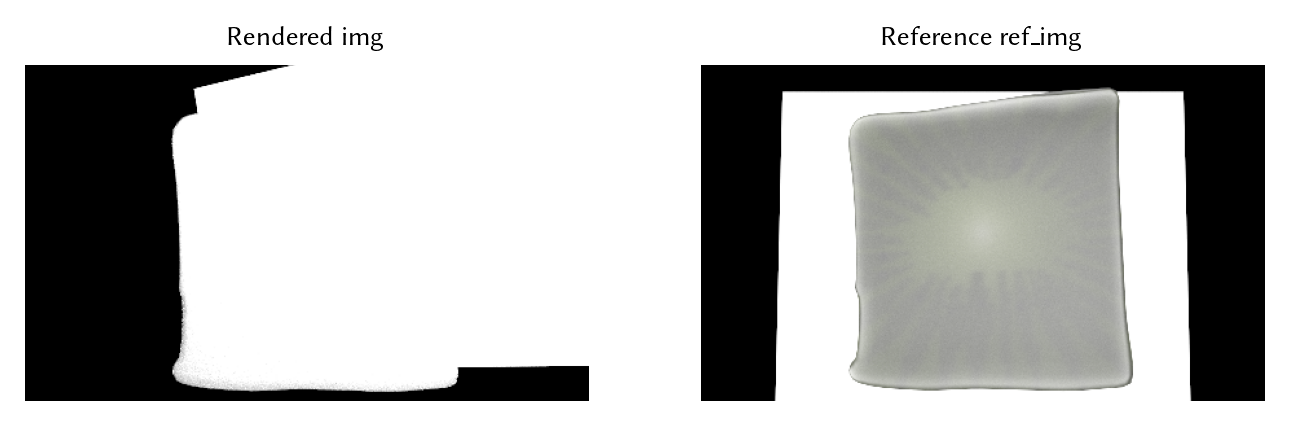

0.760098


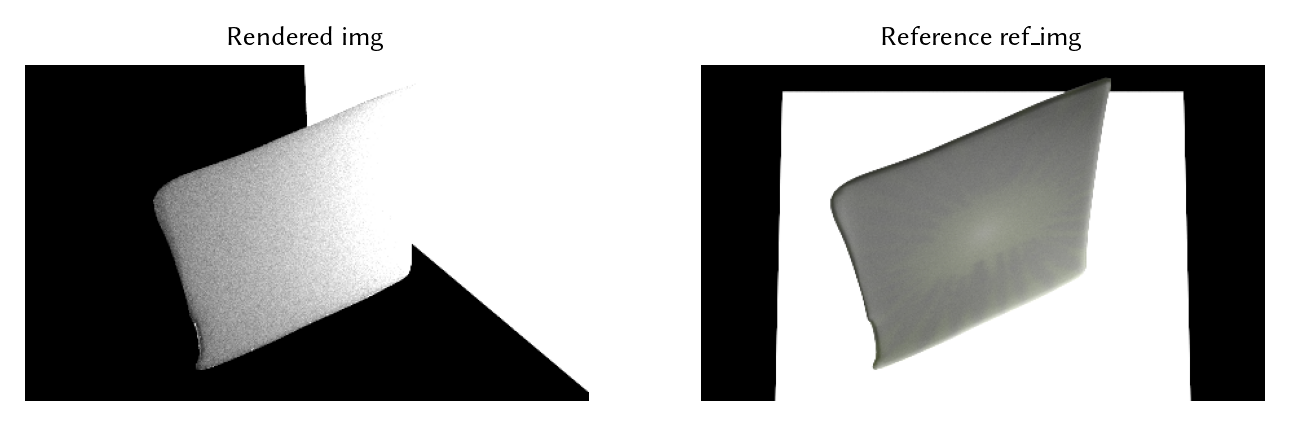

0.546216


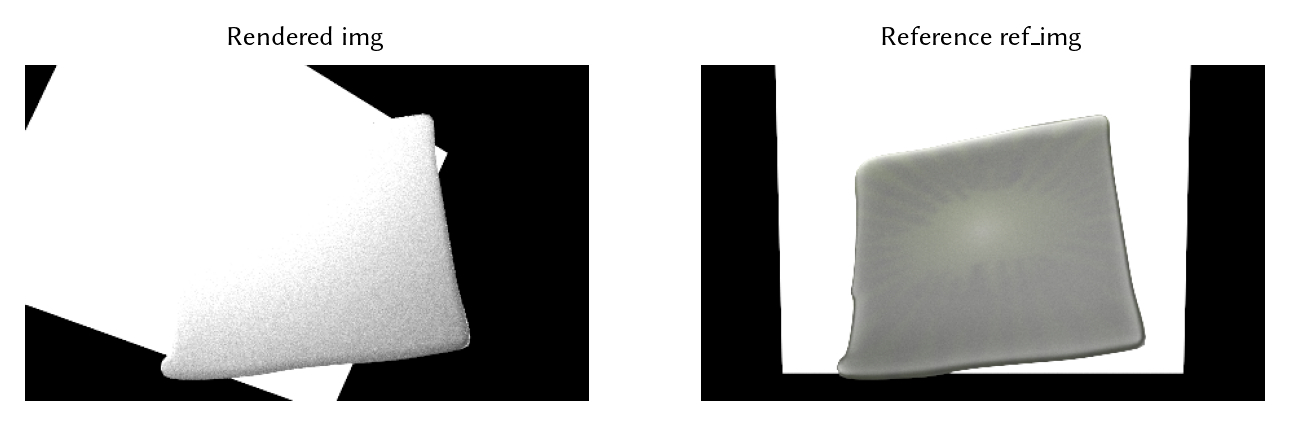

0.804008


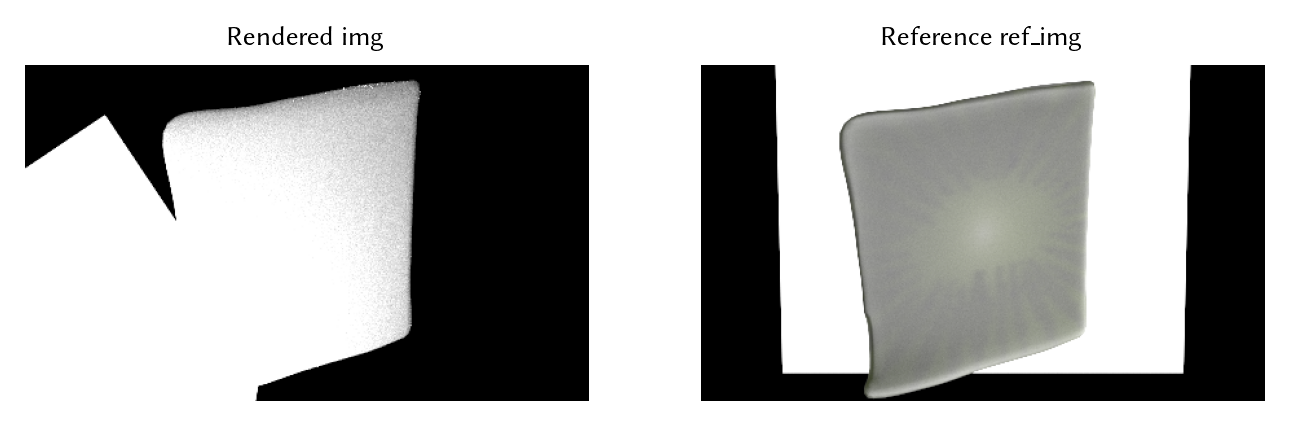

Rendering at resolution level 0 (width=436):   0%|          | 1/1024 [00:01<28:27,  1.67s/it]

0.905456


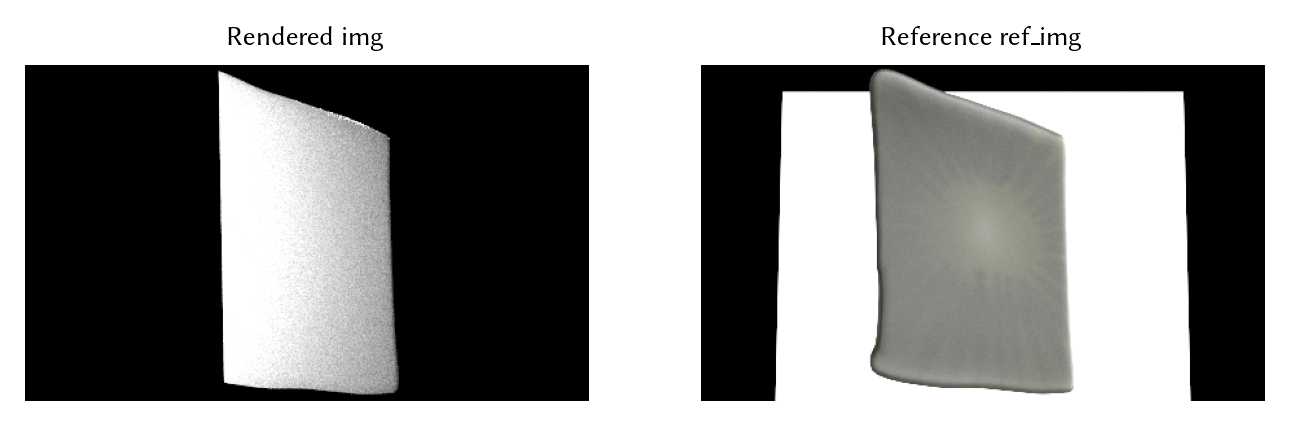

0.528519


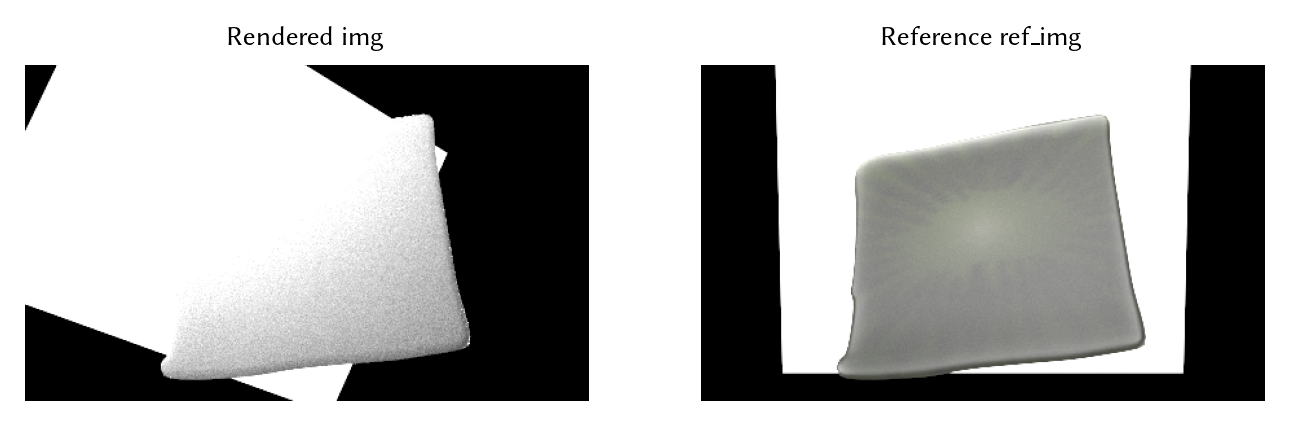

0.861733


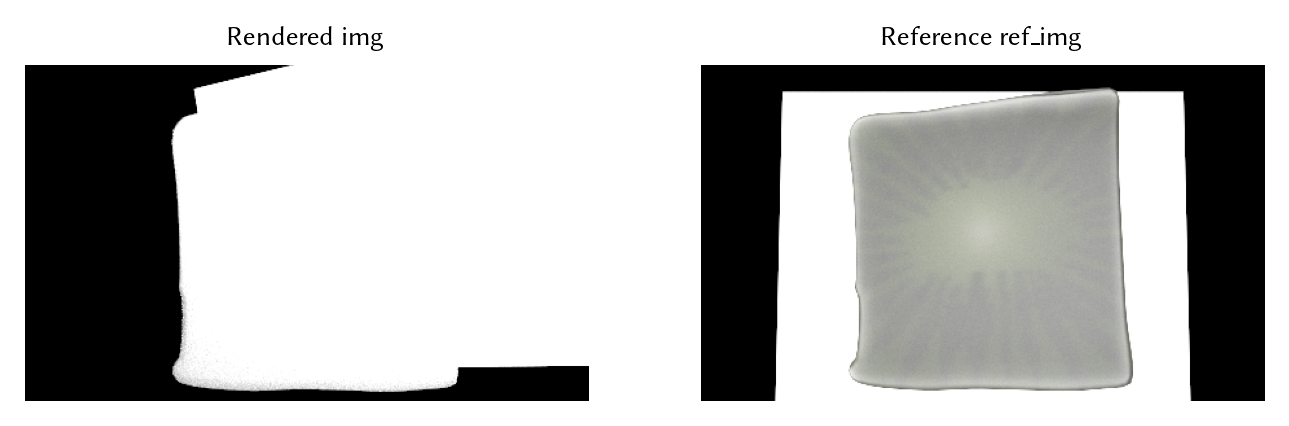

0.954305


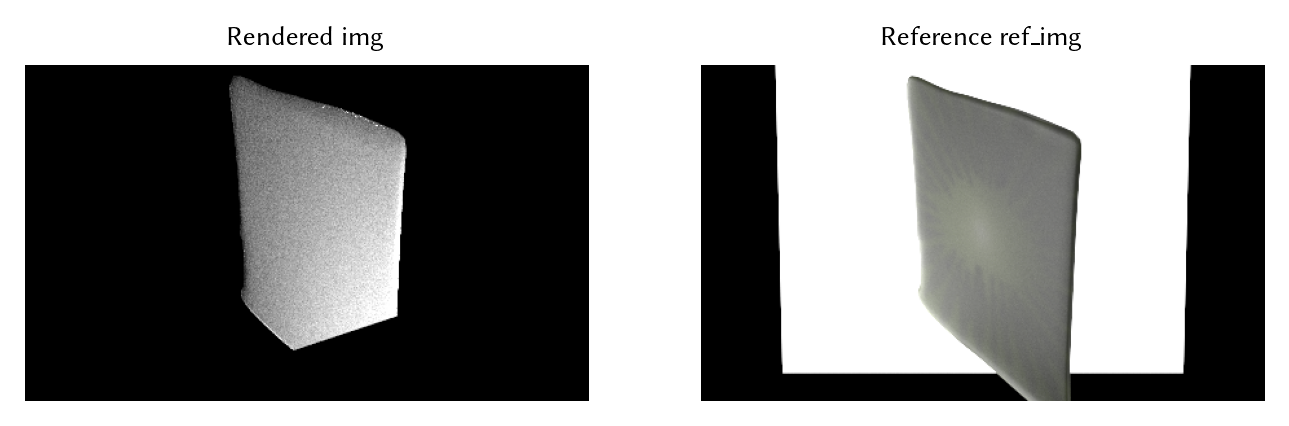

Rendering at resolution level 0 (width=436):   0%|          | 2/1024 [00:02<24:41,  1.45s/it]

0.86873


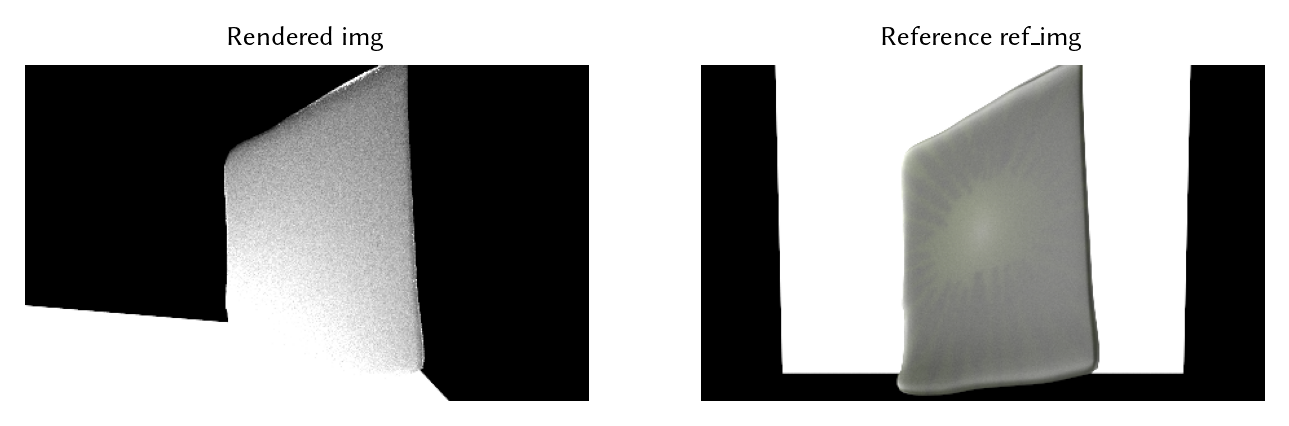

Rendering at resolution level 0 (width=436):   0%|          | 2/1024 [00:07<1:06:33,  3.91s/it]


IndexError: list index out of range

In [6]:
if technique == 'gradient_filtering':
    gin_config_name = f'{scene_name}/naive'
else:
    gin_config_name = f'{scene_name}/{technique}'

print(f'Next result location: {result_folder}')

print(scene_config)
optimization_cli.run_config(gin_config_name, override_bindings, sss_config=True)

In [ ]:
# Figure setup

def figure_grid_setup(
    fig_width,
    image_shape,
    image_crop_shape,
    inner_hspace=0.0,
    inner_wspace=0.0,
    outer_space=0.1,
):
  # Image aspect ratios
  h, w = image_shape
  h_crop, w_crop = image_crop_shape
  r = w / h
  r_crop = w_crop / h_crop

  # Spacing in the inner gridspec
  inner_wspace = inner_hspace
  # same vertical spacing as horizontal spacing
  inner_hspace = inner_wspace
  inner_rows = 2
  inner_cols = 3
  inner_height_ratios = [h_crop, h_crop]
  inner_width_ratios = [w_crop, w_crop, w_crop]
  inner_aspect = figutils.gridspec_aspect(
      n_rows=inner_rows,
      n_cols=inner_cols,
      w=inner_width_ratios,
      h=inner_height_ratios,
      wspace=inner_wspace,
      hspace=inner_hspace,
  )
  # Spacing in the main griddpec
  outer_rows = 2
  outer_cols = 1
  outer_wspace = 0
  outer_hspace = outer_space
  # If width is 1, we need the sum of the inverses for the height (single column)
  # If height is 1, we need the sum for the width (single row)
  outer_aspect = figutils.gridspec_aspect(
      n_rows=outer_rows,
      n_cols=outer_cols,
      w=[1],
      h=[1 / inner_aspect, 1 / r],
      wspace=outer_wspace,
      hspace=outer_hspace,
  )
  outer_aspect *= 0.98

  fig = plt.figure(1, figsize=(fig_width, fig_width / outer_aspect))

  outer_gs = fig.add_gridspec(
      outer_rows,
      outer_cols,
      hspace=outer_hspace,
      wspace=outer_wspace,
      height_ratios=[1 / inner_aspect, 1 / r],
      width_ratios=[1],
  )

  inner_gs = gridspec.GridSpecFromSubplotSpec(
      inner_rows,
      inner_cols,
      subplot_spec=outer_gs[0],
      wspace=inner_wspace,
      hspace=inner_hspace,
      width_ratios=inner_width_ratios,
      height_ratios=inner_height_ratios,
  )
  return (
      fig,
      outer_gs,
      inner_gs,
      inner_rows,
      inner_cols,
  )

In [ ]:
FIGURE_DIR = "figures/pdfs"
FIGURE_NAME = "volume_gradients"

ref_crop_offset = (26, 22)
ref_crop_size = (739, 432)

grad_crop_offset = (18, 13)
grad_crop_size = (363, 215)

cropped_ref_image = figutils.crop_image(ref_image,ref_crop_offset,ref_crop_size)
cropped_forward_images = [figutils.crop_image(im,grad_crop_offset,grad_crop_size) for im in forward_images]
cropped_fd_images = [figutils.crop_image(im,grad_crop_offset,grad_crop_size) for im in fd_images]

titles = [
    "Albedo",
    "Extinction",
    "Phase function (HG)",
    r"\textsc{Dragon}",
]
row_titles = ["Our forward", "Finite diff."]

params_label = [
    r"$\rho=[0.2, 0.4, 0.95]$",
    r"$\sigma_t=[15,7,5]$",
    r"$g=[-0.5, -0.2, 0.1]$",
]

(
    fig,
    outer_gs,
    inner_gs,
    inner_rows,
    inner_cols,
) = figure_grid_setup(
    figutils.COLUMN_WIDTH,
    ref_image.shape[:2],
    cropped_forward_images[0].shape[:2],
    inner_hspace=0.02,
    inner_wspace=0.02,
    outer_space=0.0,
)

title_pad = 3
label_pad = 2
line_width = 0.75

strengths = [4.5, 4.5, 4.5]
# Grads
if True:
  for row in range(inner_rows):
    for col in range(inner_cols):
      ax = fig.add_subplot(inner_gs[row, col])
      figutils.disable_ticks(ax)
      if col == 0:
        ax.set_ylabel(row_titles[row], labelpad=label_pad)
      # Our
      if row == 0:
        ax.set_title(titles[col], pad=title_pad)
        im = ax.imshow(
            cropped_forward_images[col],
            cmap=cm.coolwarm,
            vmin=-forward_vlims[col] * strengths[col],
            vmax=forward_vlims[col] * strengths[col],
        )
      elif row == 1:
        im = ax.imshow(
            cropped_fd_images[col],
            cmap=cm.coolwarm,
            vmin=-forward_vlims[col] * strengths[col],
            vmax=forward_vlims[col] * strengths[col],
        )

# Reference
if True:
  ax = fig.add_subplot(outer_gs[1])
  im = ax.imshow(cropped_ref_image)
  ax.set_ylabel(titles[-1], labelpad=label_pad)
  # ax.set_title(r"\vspace{250px}" + r"\;\;\;\;\;\;\;\;\;".join(params_label),pad=0)
  ax.set_xlabel(r"\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;".join(params_label),labelpad=label_pad)
  figutils.disable_ticks(ax)

  ax = fig.add_subplot(outer_gs[0])
  ax.axis('off')
  # Create an inset axes
  inset = inset_axes(
      ax,  # Parent axes
      width="1%",  # Width of the inset in percentage of the parent axis
      height="99.19%",  # Height of the inset in percentage of the parent axis
      loc="lower left",  # Location inside the parent axis
      bbox_to_anchor=(1.005, 0.005, 1, 1),  # Bounding box adjustment
      bbox_transform=ax.transAxes,  # Use axes coordinates
      borderpad=0,
  )  # Padding

  # Create the colorbar
  cbar = fig.colorbar(
      cm.ScalarMappable(
          norm=Normalize(
              vmin=-np.max(forward_vlims), vmax=np.max(forward_vlims)
          ),
          cmap=cm.coolwarm,
      ),
      cax=inset,
      orientation="vertical",
  )
  cbar.ax.yaxis.set_label_position("left")  # Move label to the left
  # cbar.ax.yaxis.tick_left()  # Move ticks to the left side
  cbar.set_label("Parameter gradient", labelpad=-9)
  ticks = [cbar.vmin, cbar.vmax]
  cbar.set_ticks(ticks)
  # cbar.set_ticklabels([f"{x:.2f}" for x in ticks])
  cbar.set_ticklabels(["neg", "pos"])
  cbar.ax.tick_params(pad=1.8, length=0)

# fig.tight_layout()
figutils.force_post_crop_size(fig, figutils.COLUMN_WIDTH)

In [ ]:
figutils.savefig(
    fig,
    name=Path(FIGURE_NAME),
    fig_directory=Path(FIGURE_DIR),
    dpi=300,
    pad_inches=0.005,
    bbox_inches="tight",
    compress=False,
    target_width=figutils.COLUMN_WIDTH,
    backend=None,
)